<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_standard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-processing and analysis of single-cell RNA-seq data with kallisto|bustools.

This notebook demonstrates pre-processing and analysis of the [mouse retinal cells SRR8599150](https://www.ncbi.nlm.nih.gov/sra/?term=SRR8599150) dataset from [Koren et al., 2019](https://doi.org/10.1016/j.immuni.2019.02.007) using the **kallisto | bustools** workflow, implemented with a wrapper called `kb`. The approximate running time is 12 minutes.

The notebook was written by Kyung Hoi (Joseph) Min, A. Sina Booeshaghi and Lior Pachter.

In [1]:
!date

Fri Jan 17 05:12:02 UTC 2020


## Pre-processing

### Downloading the data

__Note:__ We use the `-O` option for `wget` to rename the files so they can be easily identified. The notebook requires reads in fastq format; the files can be processed in gzip compressed format.

In this example the reads are downloaded from a Box drive; see the [data download](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/data_download.ipynb) notebook for information on where to find publicly available single-cell RNA-seq data.

In [2]:
%%time
!wget https://caltech.box.com/shared/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt -O checksums.txt
!wget https://caltech.box.com/shared/static/w9ww8et5o029s2e3usjzpbq8lpot29rh.gz -O SRR8599150_S1_L001_R1_001.fastq.gz
!wget https://caltech.box.com/shared/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz -O SRR8599150_S1_L001_R2_001.fastq.gz

--2020-01-17 05:12:04--  https://caltech.box.com/shared/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt
Resolving caltech.box.com (caltech.box.com)... 107.152.27.197, 107.152.26.197
Connecting to caltech.box.com (caltech.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt [following]
--2020-01-17 05:12:04--  https://caltech.box.com/public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt [following]
--2020-01-17 05:12:04--  https://caltech.app.box.com/public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.27.199, 107.152.26.199
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.27.199|:443... connected.
HTTP requ



```
# This is formatted as code
```

Next, we verify the integrity of the files that were downloaded to confirm that they were not corrupted during the download.

In [3]:
!md5sum -c checksums.txt --ignore-missing

SRR8599150_S1_L001_R1_001.fastq.gz: OK
SRR8599150_S1_L001_R2_001.fastq.gz: OK


### Installing `kb`
Install `kb` for running the kallisto|bustools workflow:

In [4]:
!pip install kb-python

     |████████████████████████████████| 35.4MB 78kB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 51kB 9.9MB/s 
     |████████████████████████████████| 51kB 9.9MB/s 
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47896 sha256=ba52829829d052867a6a3ca70ece57419d5b15851733fe5ed2019d51e121ef19
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0+unknown-cp36-none-any.whl size=28044 sha256=9b17be13a36368bd3098f648bd747ce8ed77f201012c4596e275b2201210d7d5
  Stored in directory: /root/.cache/pip/wheels/30/ac/83/64d5f9293aeaec63f9539142fc629a41af064cae1b3d8d94aa
Successfully built loompy numpy-groupies


### Downloading a pre-built mouse index

__Note:__ See [this notebook](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_transcriptome_index.ipynb) for a tutorial on how to build custom transcriptome indices or indices for RNA velocity.

In [5]:
%%time
!kb ref -d mouse -i index.idx -g t2g.txt

[2020-01-17 05:13:01,790]    INFO Downloading files for mouse from https://caltech.box.com/shared/static/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz to tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz
[2020-01-17 05:14:49,519]    INFO Extracting files from tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz
CPU times: user 369 ms, sys: 54.8 ms, total: 424 ms
Wall time: 2min 24s


### Generating an RNA count matrix in H5AD format

The following command will generate an RNA count matrix of cells (rows) by genes (columns) in H5AD format, which is a binary format used to store [Anndata](https://anndata.readthedocs.io/en/stable/) objects. Notice that this requires providing the index and transcript-to-gene mapping downloaded in the previous step to the `-i` and `-g` arguments respectively. Also, since the reads were generated with the 10x Genomics Chromium Single Cell v2 Chemistry, the `-x 10xv2` argument is used. To view other supported technologies, run `kb --list`.

__Note:__ To output a [Loom](https://linnarssonlab.org/loompy/format/index.html) file instead, replace the `--h5ad` flag with `--loom`. To obtain the raw matrix output by `kb` instead of the H5AD or Loom converted files, omit these flags.

In [6]:
%%time
!kb count -i index.idx -g t2g.txt -x 10xv2 --h5ad -t 2 \
SRR8599150_S1_L001_R1_001.fastq.gz SRR8599150_S1_L001_R2_001.fastq.gz

[2020-01-17 05:15:31,987]    INFO Generating BUS file from
[2020-01-17 05:15:31,987]    INFO         SRR8599150_S1_L001_R1_001.fastq.gz
[2020-01-17 05:15:31,987]    INFO         SRR8599150_S1_L001_R2_001.fastq.gz
[2020-01-17 05:17:45,292]    INFO Sorting BUS file ./output.bus to tmp/output.s.bus
[2020-01-17 05:17:48,477]    INFO Whitelist not provided
[2020-01-17 05:17:48,477]    INFO Copying pre-packaged 10XV2 whitelist to .
[2020-01-17 05:17:48,579]    INFO Inspecting BUS file tmp/output.s.bus
[2020-01-17 05:17:49,967]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist ./10xv2_whitelist.txt
[2020-01-17 05:18:04,234]    INFO Sorting BUS file tmp/output.s.c.bus to ./output.unfiltered.bus
[2020-01-17 05:18:07,162]    INFO Generating count matrix ./counts_unfiltered/cells_x_genes from BUS file ./output.unfiltered.bus
[2020-01-17 05:18:09,202]    INFO Converting matrix ./counts_unfiltered/cells_x_genes.mtx to h5ad ./counts_unfiltered/adata.h5ad
CPU tim

## Analysis

In this part of the tutorial, the RNA count matrix generated by `kb count` is loaded into Python and the cells are cluster by [Louvain community detection](https://en.wikipedia.org/wiki/Louvain_modularity).

### Installing packages

Google Colab does not come with `Scanpy`, `python-igraph`, or `louvain` (but  `matplotlib`, `numpy`, `pandas`, and `scipy` are provided).

In [7]:
%%time
!pip install scanpy python-igraph louvain MulticoreTSNE

     |████████████████████████████████| 317kB 3.4MB/s 
     |████████████████████████████████| 378kB 56.2MB/s 
     |████████████████████████████████| 92kB 13.5MB/s 
     |████████████████████████████████| 13.0MB 27.1MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.7.1.post6-cp36-cp36m-linux_x86_64.whl size=2217207 sha256=e406ea7abccb83af58a7513e4d06f17a5eb3ca9c8228f150ffee193a40c56fe3
  Stored in directory: /root/.cache/pip/wheels/41/d6/02/34eebae97e25f5b87d60f4c0687e00523e3f244fa41bc3f4a7
  Created wheel for louvain: filename=louvain-0.6.1-cp36-cp36m-linux_x86_64.whl size=1024856 sha256=1f44920ed6b204b697670f354721f802c52b4ac6b2914b0ee2b0a3b4ca626d79
  Stored in directory: /root/.cache/pip/wheels/f2/c3/d4/f7abaf064186d6214ef952bbb72fd6c5136d4b17dbeaeff481
  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68507 sha256=c53035fe6989919cf4804972a9f1572c771c81ec0738c0d946a2c

CPU times: user 1.1 s, sys: 110 ms, total: 1.21 s
Wall time: 5min


### Importing packages

In [0]:
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import sparse, io

matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'

### Importing the H5AD-formatted Anndata matrix

In [0]:
adata = anndata.read('counts_unfiltered/adata.h5ad')

In [10]:
adata

AnnData object with n_obs × n_vars = 96775 × 55421 

### Making the knee plot

In [0]:
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

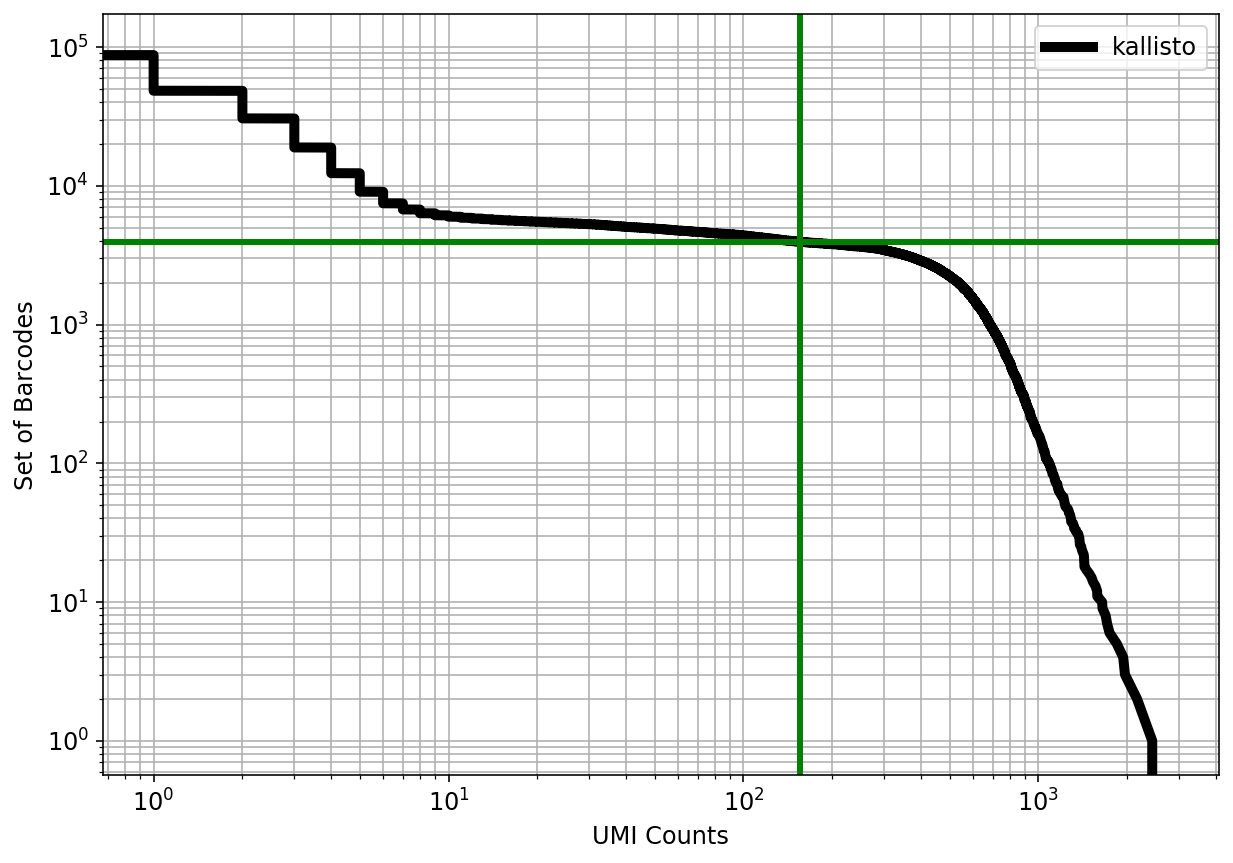

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))

expected_num_cells=3949

ax.loglog(knee, range(len(knee)), label="kallisto", linewidth=5, color="k")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="g")
ax.axhline(y=expected_num_cells, linewidth=3, color="g")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
ax.legend()
plt.show()

### Filtering with ScanPy

In [0]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_cells(adata, min_counts=knee[expected_num_cells])
sc.pp.filter_genes(adata, min_cells=0)

In [14]:
adata

AnnData object with n_obs × n_vars = 3950 × 55421 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells'

### Visualizing gene and count distributions

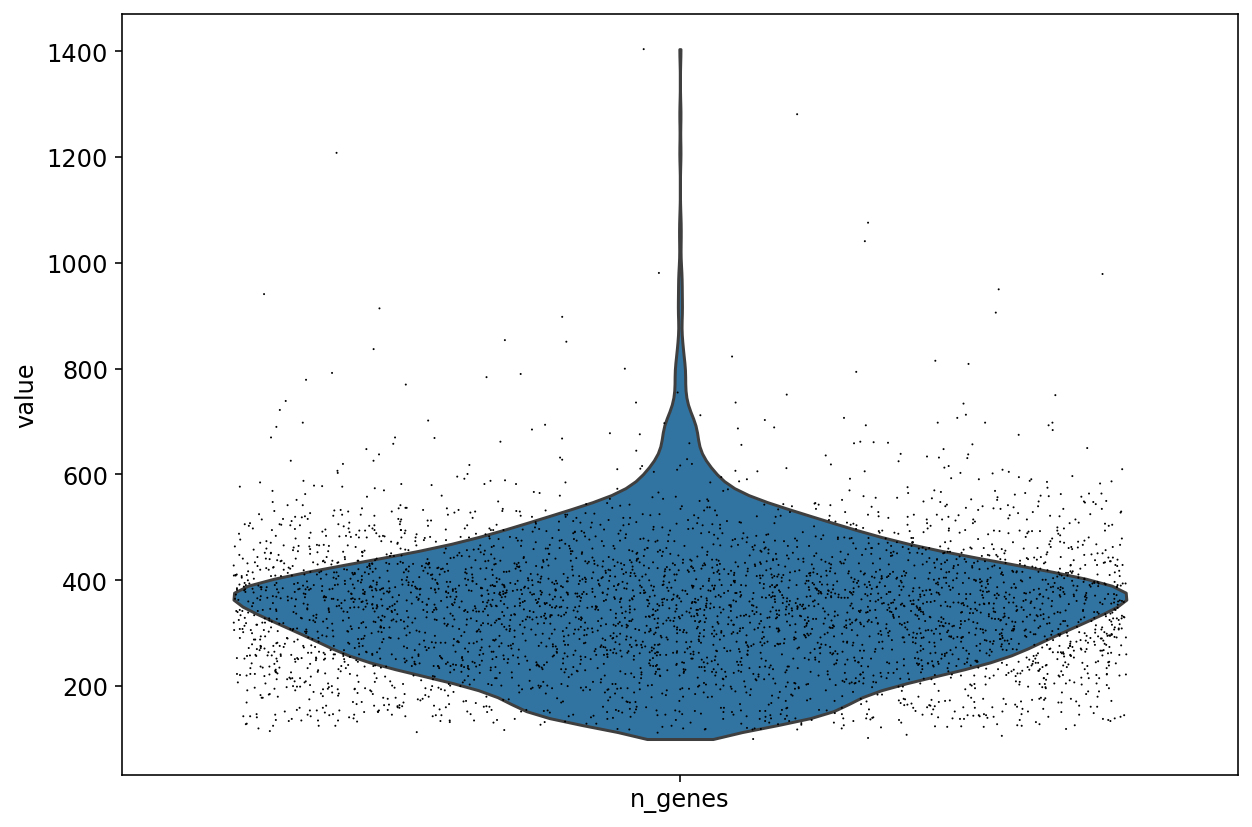

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.violin(adata, 'n_genes', jitter=0.4, ax=ax)

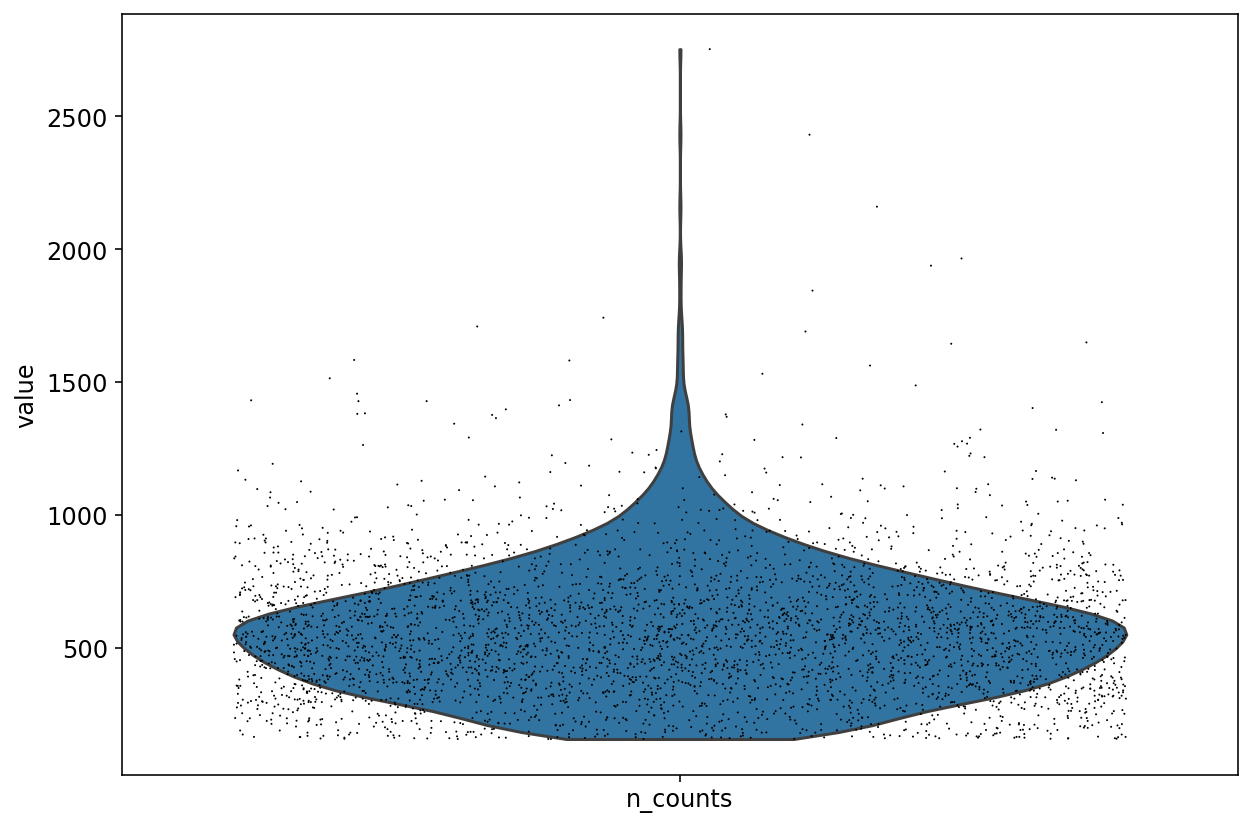

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.violin(adata, 'n_counts', jitter=0.4, ax=ax)

### Normalizing the counts in the matrix

In [0]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# apply log(1 + count) to all counts
adata.raw = sc.pp.log1p(adata, copy=True)
sc.pp.log1p(adata)

### View highly variable genes

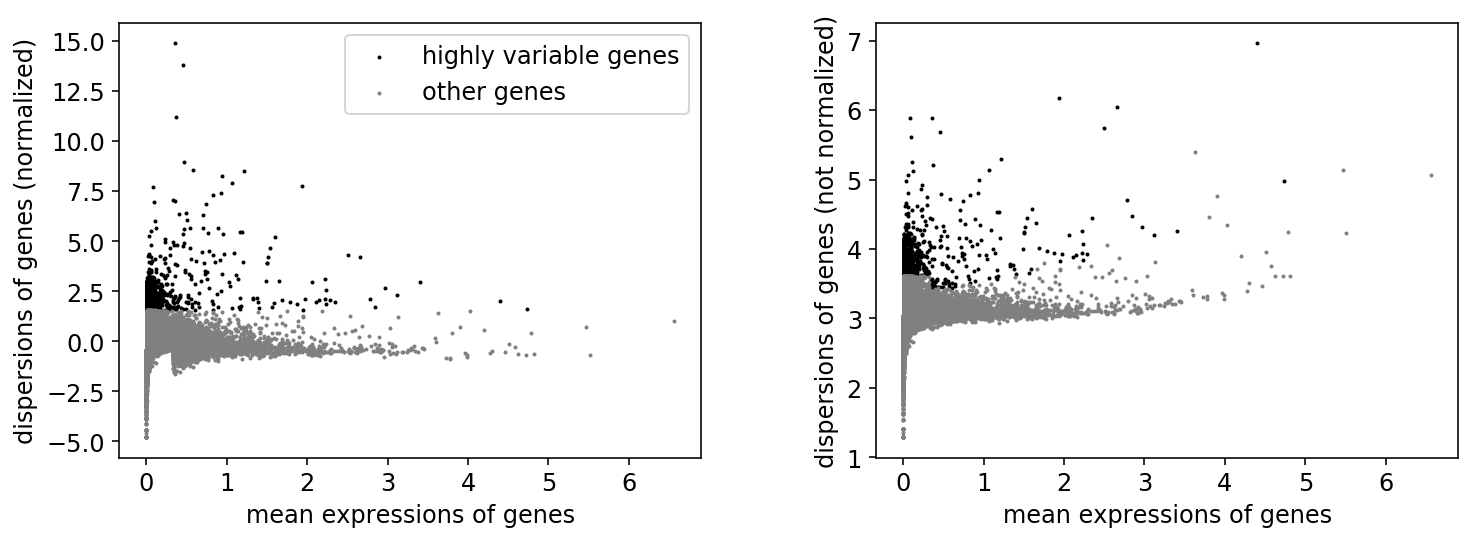

In [18]:
filter_result = sc.pp.highly_variable_genes(adata, min_disp=0.3, inplace=False, n_top_genes=1209)
sc.pl.highly_variable_genes(filter_result)

In [19]:
print("{:,} highly variable genes".format(sum(x[0] for x in filter_result)))

1,209 highly variable genes


### Louvain clustering and visualization

In [20]:
%%time
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.louvain(adata)

CPU times: user 1min 16s, sys: 1.41 s, total: 1min 18s
Wall time: 42.3 s


### PCA

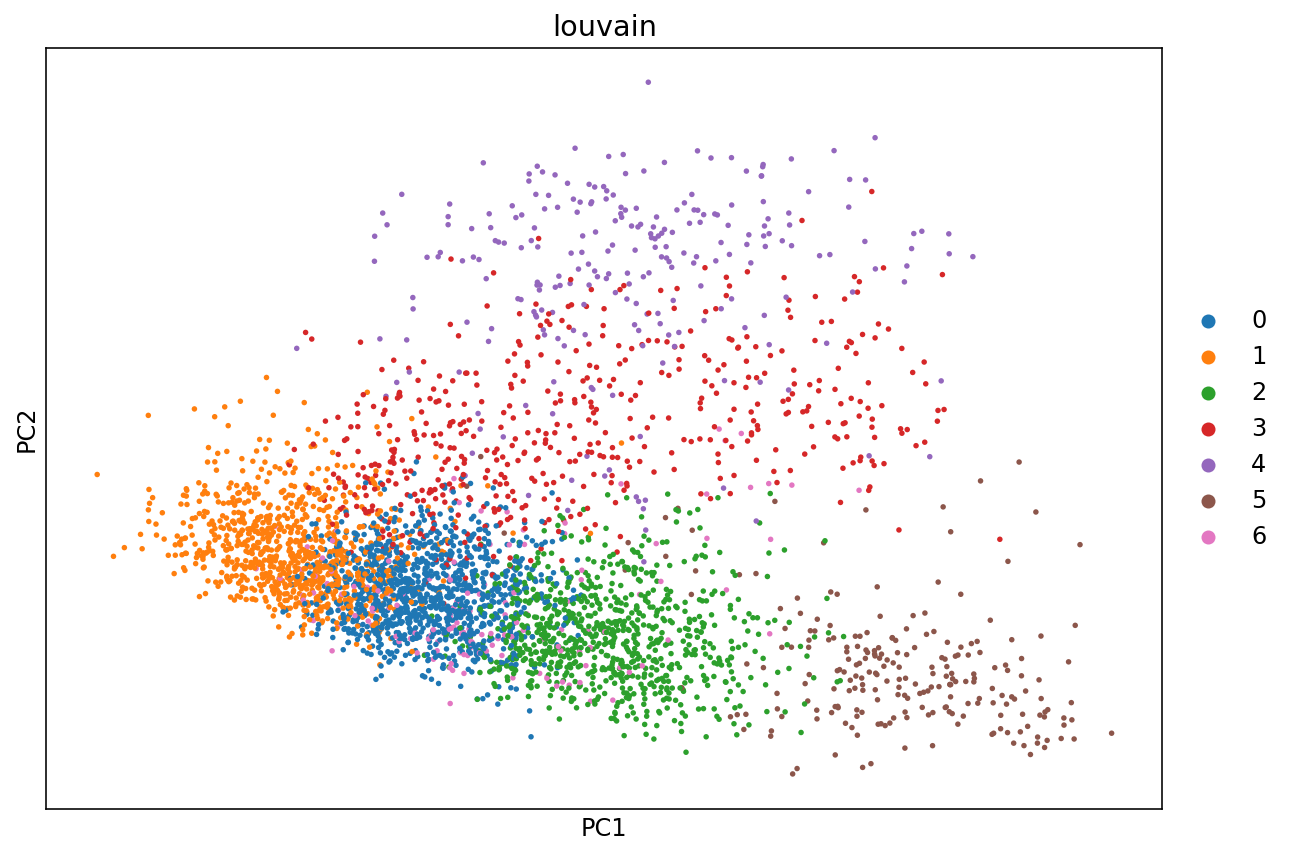

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata, color='louvain', ax=ax)

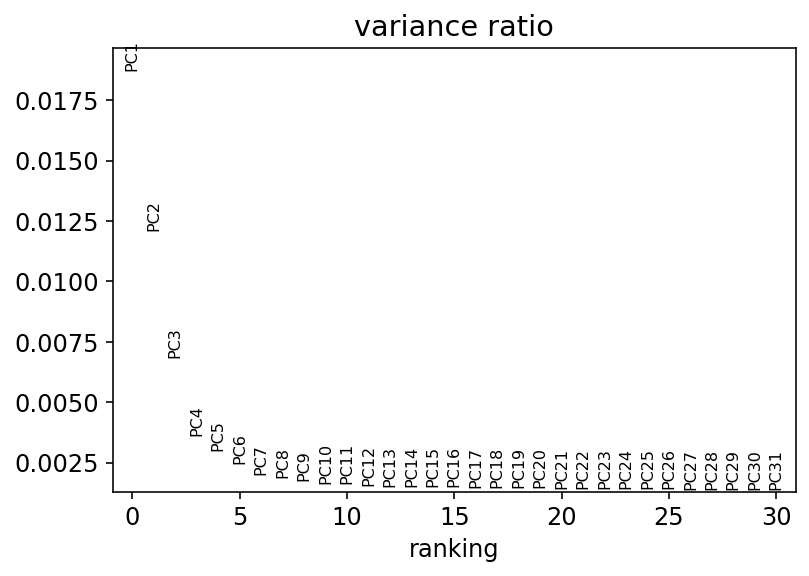

In [22]:
sc.pl.pca_variance_ratio(adata)

### UMAP

In [23]:
%%time
sc.tl.umap(adata)

CPU times: user 11.1 s, sys: 144 ms, total: 11.2 s
Wall time: 11.1 s


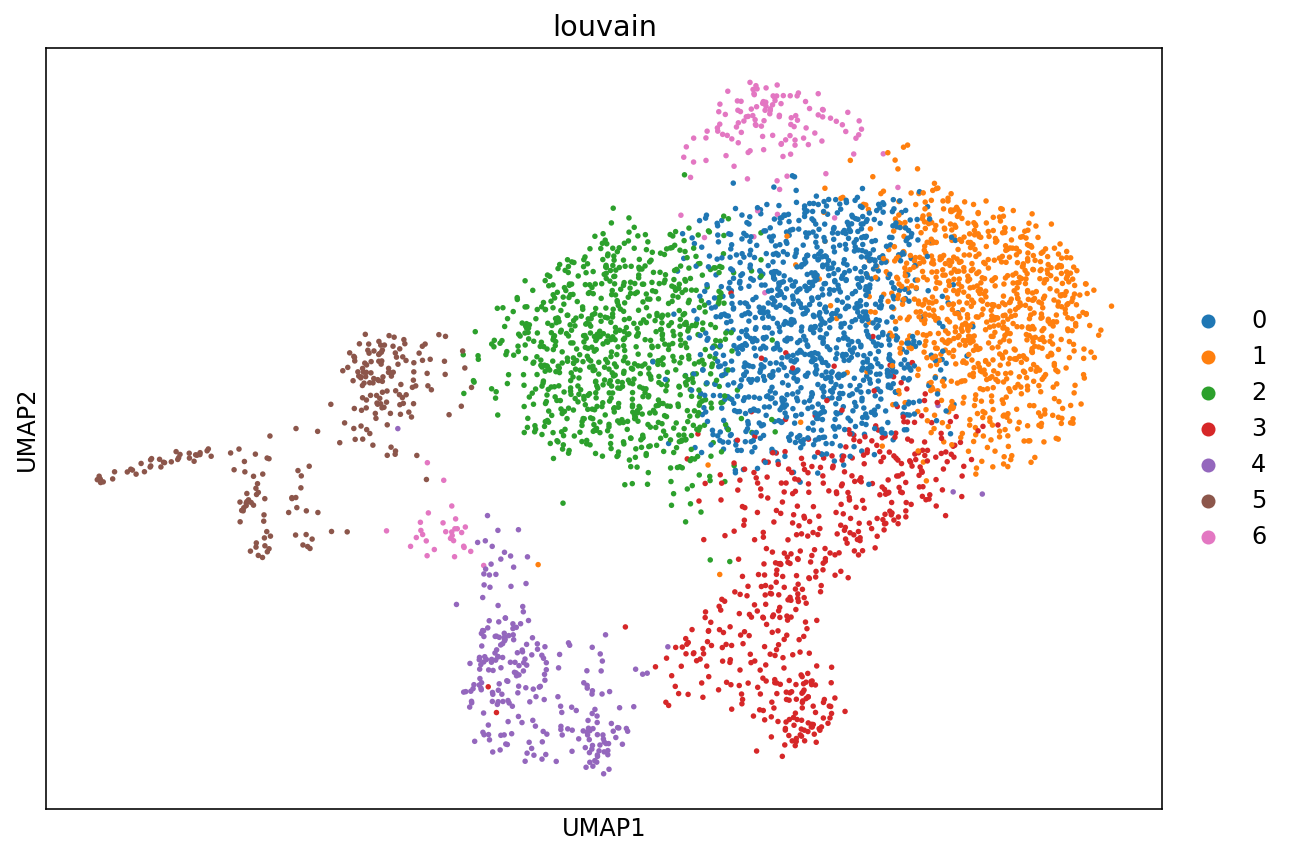

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='louvain', ax=ax)

### tSNE

In [25]:
%%time
sc.tl.tsne(adata, n_pcs=10)

CPU times: user 23.3 s, sys: 8.58 ms, total: 23.3 s
Wall time: 23.3 s


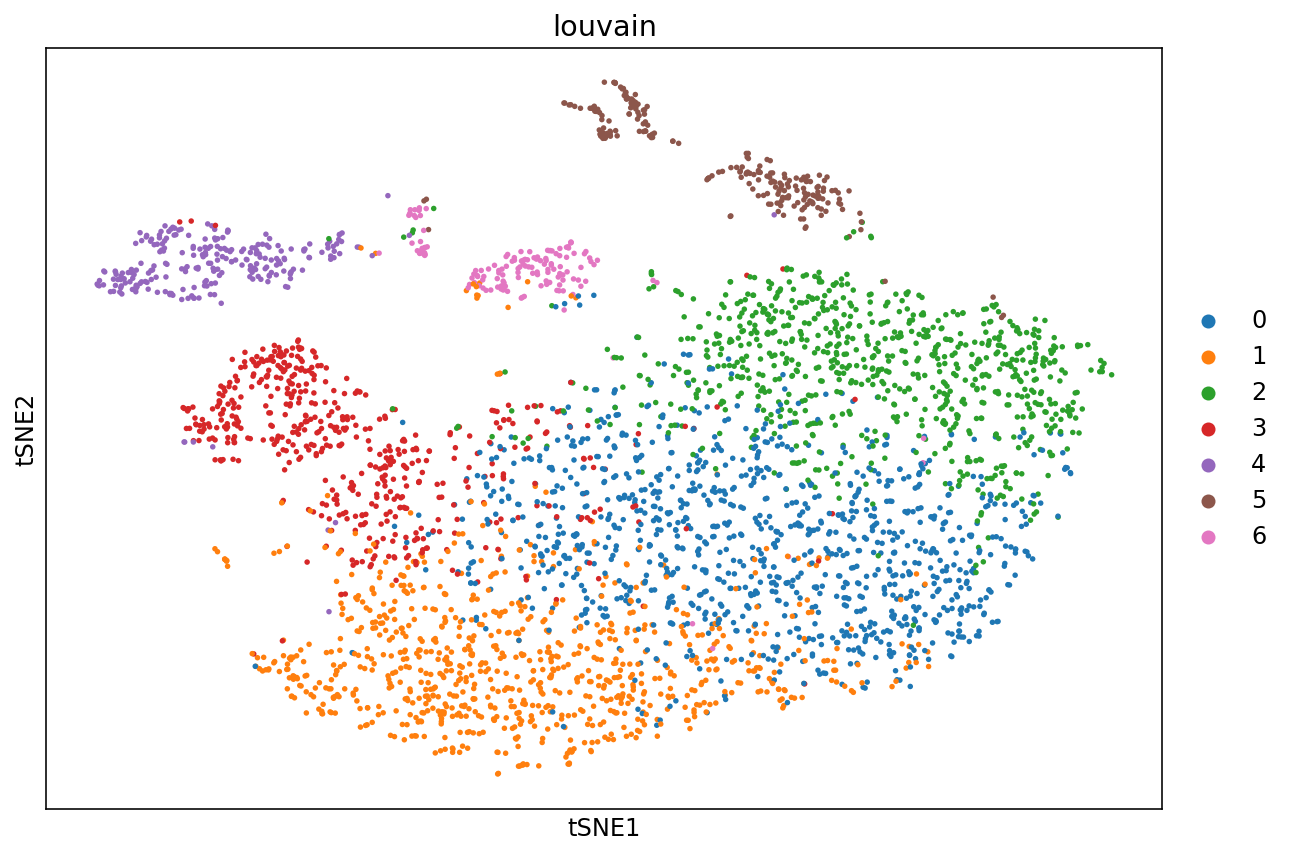

In [26]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.tsne(adata, color='louvain', ax=ax)

In [27]:
!date

Fri Jan 17 05:24:42 UTC 2020
